#ARIMA

Tipico workflow ARIMA:

Differenziazione → trovi d

PACF sulla serie differenziata → scegli p

ACF sulla serie differenziata → scegli q

###Importazione e pulizia

Eliminazione colonna Unnamed: 0
Cambio del formato della colonna Date (da object a date)
Cambio nome della colonna Monthly Mean Total Sunspot Number a Monthly_Mean_Tot_Sunspot_N

In [1]:
import pandas as pd
path = '/content/Sunspots.csv'
data = pd.read_csv(path)
data.head(20)

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
5,5,1749-06-30,139.2
6,6,1749-07-31,158.0
7,7,1749-08-31,110.5
8,8,1749-09-30,126.5
9,9,1749-10-31,125.8


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3265 non-null   int64  
 1   Date                               3265 non-null   object 
 2   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.7+ KB


In [3]:
data = data.drop(columns=['Unnamed: 0'])
data = data.rename(columns={'Monthly Mean Total Sunspot Number': 'Monthly_Mean_Tot_Sunspot_N'})
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3265 entries, 1749-01-31 to 2021-01-31
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Monthly_Mean_Tot_Sunspot_N  3265 non-null   float64
dtypes: float64(1)
memory usage: 51.0 KB


###Analisi della stazionarietà della serie prima di applicare il modello

eseguiamo il test di Dickey-Fuller aumentato (ADF), che serve a verificare se una serie temporale è stazionaria — cioè se non ha trend, né varianza variabile nel tempo

In [4]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['Monthly_Mean_Tot_Sunspot_N'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.497052
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


secondo il test ADF la nostra serie è stazionaria, cioè non ha un trend di stagionalità

Abbiamo trovato che la nostra d=0

###PACF - Partial Autocorrelation Function

Il PACF misura la correlazione diretta tra un'osservazione e le sue osservazioni passate rispetto a lag specifici.

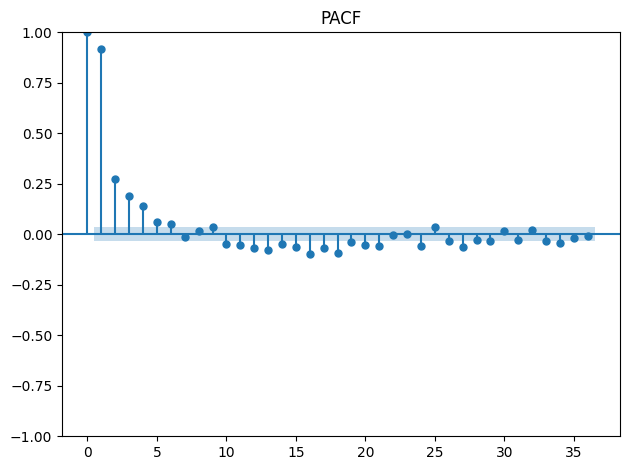

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plot_pacf(data.Monthly_Mean_Tot_Sunspot_N, title='PACF')
plt.tight_layout()
plt.show()

Contiamo i marker fuori dall'aria di confidenza, ci fermiamo a 5, quindi p=5

###ACF - Autocorrelation Function

Misura la correlazione totale

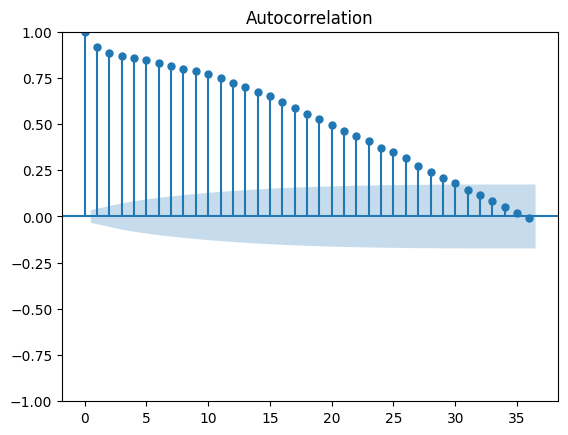

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(data.Monthly_Mean_Tot_Sunspot_N)
plt.show()


q non è rilevante in quanto la curva è regolare, 'morbida' ma lo settiamo comunque a 29, che sono i marker al di sopra dell'area di condidenza. q=29

Quando l'ACF NON ha cutoff brusco ma decresce gradualmente, indica:
Serie con forte componente AR (AutoRegressiva)

La serie dipende lievemente dai suoi valori passati,
in quanto i sunspot hanno solitamente cicli di circa 11 anni.

###Addestramento del modello ARIMA

In questo box addestriamo il modello con i parametri trovati nelle analisi precedenti (la sintassi è p, d, q)

In [7]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data['Monthly_Mean_Tot_Sunspot_N'], order=(5, 0, 29))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                    
======================================================================================
Dep. Variable:     Monthly_Mean_Tot_Sunspot_N   No. Observations:                 3265
Model:                        ARIMA(5, 0, 29)   Log Likelihood              -15037.301
Date:                        Tue, 17 Jun 2025   AIC                          30146.601
Time:                                08:31:58   BIC                          30365.878
Sample:                            01-31-1749   HQIC                         30225.136
                                 - 01-31-2021                                         
Covariance Type:                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.7761      5.872     13.926      0.000      70.267      93.286
ar.L1          0.8930      0.125      7.153      0.000       0.648       1.138
ar.L2          0.2147      0.171      1.259      0.208      -0.120       0.549
ar.L3         -0.0346      0.174     -0.199      0.842      -0.376       0.306
ar.L4          0.7404      0.165      4.495      0.000       0.418       1.063
ar.L5         -0.8234      0.117     -7.024      0.000      -1.053      -0.594
ma.L1         -0.3615      0.126     -2.875      0.004      -0.608      -0.115
ma.L2         -0.3158      0.134     -2.358      0.018      -0.578      -0.053
ma.L3         -0.0876      0.153     -0.573      0.567      -0.387       0.212
ma.L4         -0.7467      0.145     -5.160      0.000      -1.030      -0.463
ma.L5          0.3910      0.058      6.758      0.000       0.278       0.504
ma.L6          0.1545      0.029      5.410      0.000       0.099       0.211
ma.L7          0.0121      0.020      0.590      0.555      -0.028       0.052
ma.L8         -0.0187      0.020     -0.918      0.359      -0.059       0.021
ma.L9          0.1046      0.022      4.711      0.000       0.061       0.148
ma.L10         0.0052      0.026      0.204      0.838      -0.045       0.056
ma.L11         0.0267      0.024      1.105      0.269      -0.021       0.074
ma.L12         0.0064      0.022      0.290      0.772      -0.037       0.050
ma.L13        -0.0821      0.023     -3.639      0.000      -0.126      -0.038
ma.L14         0.0174      0.021      0.820      0.412      -0.024       0.059
ma.L15         0.0313      0.020      1.542      0.123      -0.008       0.071
ma.L16        -0.0396      0.023     -1.753      0.080      -0.084       0.005
ma.L17         0.0133      0.024      0.559      0.576      -0.033       0.060
ma.L18        -0.0523      0.023     -2.232      0.026      -0.098      -0.006
ma.L19        -0.0078      0.024     -0.331      0.741      -0.054       0.038
ma.L20         0.0390      0.022      1.790      0.073      -0.004       0.082
ma.L21        -0.0429      0.022     -1.917      0.055      -0.087       0.001
ma.L22         0.0283      0.024      1.178      0.239      -0.019       0.075
ma.L23         0.0491      0.024      2.011      0.044       0.001       0.097
ma.L24        -0.0497      0.025     -2.011      0.044      -0.098      -0.001
ma.L25         0.0847      0.026      3.321      0.001       0.035       0.135
ma.L26         0.0180      0.023      0.796      0.426      -0.026       0.062
ma.L27        -0.0823      0.024     -3.496      0.000      -0.128      -0.036
ma.L28         0.0429      0.026      1.639      0.101      -0.008       0.094
ma.L29        -0.0354      0.024     -1.449      0.147      -0.083       0.012
sigma2       590.4770      9.965     59.255      0.000     570.946     610.008
===================================================================================
Ljun

###Grafico di train e previsione concatenati

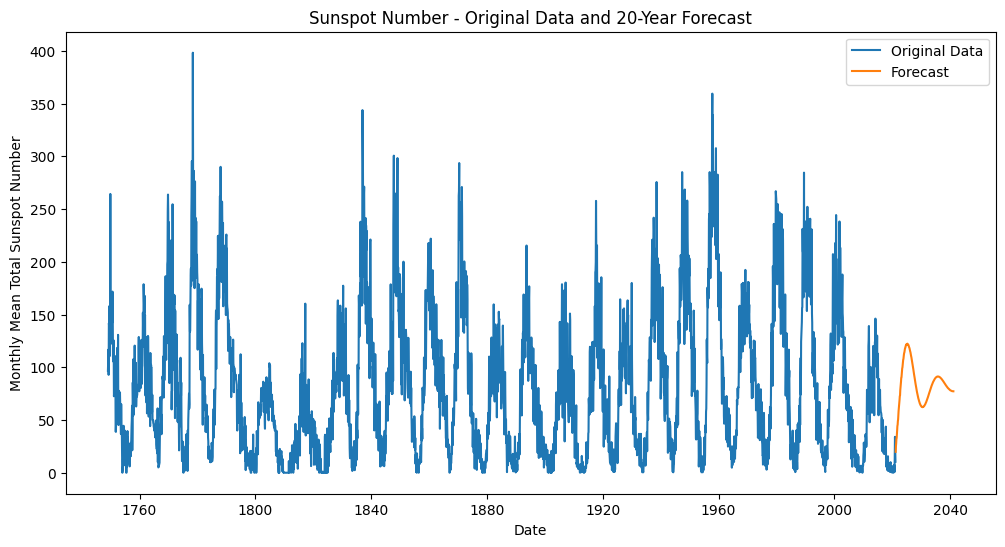

In [8]:
import matplotlib.pyplot as plt
forecast_periods = 240
forecast = model_fit.forecast(steps=forecast_periods)

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Monthly_Mean_Tot_Sunspot_N'], label='Original Data')
plt.plot(forecast.index, forecast, label='Forecast')
plt.title('Sunspot Number - Original Data and 20-Year Forecast')
plt.xlabel('Date')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

test = data['Monthly_Mean_Tot_Sunspot_N'][-240:]
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 57.77
Mean Squared Error (MSE): 4417.04
Root Mean Squared Error (RMSE): 66.46


L'errore è alto ma per i periodi immediatamente successivi all'ultima data di train, il modello riesce a prevedere in maniera abbastanza accurata il trend della serie per circa 20 anni.

###Modelli con valori alternativi

Per provare che q è un parametro ininfluente, lo abbiamo abbassato da 29 a 15

In [10]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data['Monthly_Mean_Tot_Sunspot_N'], order=(5, 0, 15))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                    
======================================================================================
Dep. Variable:     Monthly_Mean_Tot_Sunspot_N   No. Observations:                 3265
Model:                        ARIMA(5, 0, 15)   Log Likelihood              -15055.729
Date:                        Tue, 17 Jun 2025   AIC                          30155.459
Time:                                08:32:44   BIC                          30289.461
Sample:                            01-31-1749   HQIC                         30203.452
                                 - 01-31-2021                                         
Covariance Type:                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.7756      5.536     14.772      0.000      70.925      92.626
ar.L1         -0.0548      0.254     -0.216      0.829      -0.552       0.442
ar.L2          1.2550      0.152      8.279      0.000       0.958       1.552
ar.L3          0.8895      0.271      3.285      0.001       0.359       1.420
ar.L4         -0.4706      0.121     -3.899      0.000      -0.707      -0.234
ar.L5         -0.6323      0.225     -2.807      0.005      -1.074      -0.191
ma.L1          0.5845      0.254      2.304      0.021       0.087       1.082
ma.L2         -0.8538      0.069    -12.424      0.000      -0.989      -0.719
ma.L3         -1.2110      0.241     -5.027      0.000      -1.683      -0.739
ma.L4         -0.1074      0.200     -0.536      0.592      -0.500       0.286
ma.L5          0.4820      0.127      3.808      0.000       0.234       0.730
ma.L6          0.1496      0.047      3.187      0.001       0.058       0.242
ma.L7          0.0191      0.030      0.639      0.523      -0.040       0.078
ma.L8         -0.0128      0.026     -0.486      0.627      -0.064       0.039
ma.L9          0.0792      0.029      2.759      0.006       0.023       0.136
ma.L10         0.1123      0.030      3.696      0.000       0.053       0.172
ma.L11         0.0139      0.031      0.442      0.659      -0.048       0.075
ma.L12        -0.0721      0.026     -2.735      0.006      -0.124      -0.020
ma.L13        -0.0653      0.024     -2.688      0.007      -0.113      -0.018
ma.L14        -0.0132      0.019     -0.699      0.484      -0.050       0.024
ma.L15         0.0273      0.018      1.533      0.125      -0.008       0.062
sigma2       590.2599      9.678     60.991      0.000     571.292     609.228
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1553.75
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.58
Prob(H) (two-sided):                  0.06   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

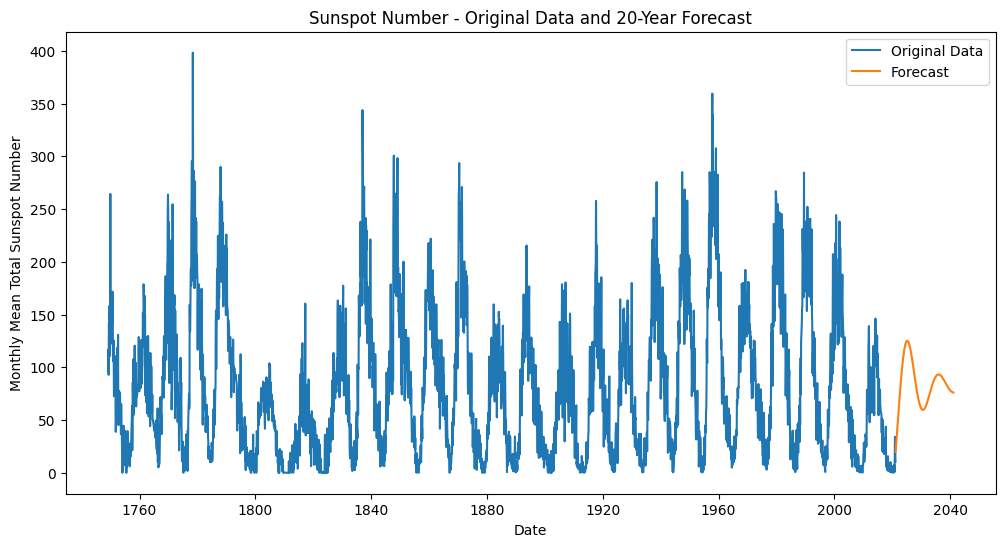

In [11]:
import matplotlib.pyplot as plt
forecast_periods = 240
forecast = model_fit.forecast(steps=forecast_periods)

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Monthly_Mean_Tot_Sunspot_N'], label='Original Data')
plt.plot(forecast.index, forecast, label='Forecast')
plt.title('Sunspot Number - Original Data and 20-Year Forecast')
plt.xlabel('Date')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.legend()
plt.show()

In [12]:
import matplotlib.pyplot as plt
forecast_periods = 240
forecast = model_fit.forecast(steps=forecast_periods)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

test = data['Monthly_Mean_Tot_Sunspot_N'][-240:]
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 58.47
Mean Squared Error (MSE): 4511.42
Root Mean Squared Error (RMSE): 67.17


I valori degli errori sono lievemente cambiati ma restano sulla stessa soglia, l'andamento rimane molto simile a quello trovato con i parametri precedenti.

Questo conferma la poca influenza della variazione del parametro q.